# Water Content Prediction Model

Made for barby by awesome maggie


## Imports


In [ ]:
# Install necessary libraries
!pip install torch torchvision matplotlib scikit-image imageio[pyav]

In [3]:
# Import necessary libraries
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import imageio
from skimage import io
import torch.optim as optim




## Create Custom Classes


In [186]:
class SoilDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, transform=None, num_augmentations=1):
        self.root_dir = root_dir
        self.transform = transform
        self.num_augmentations = num_augmentations
        self.images = []
        self.labels = []

        for folder in os.listdir(root_dir):
            folder_path = os.path.join(root_dir, folder)
            if os.path.isdir(folder_path):
                try:
                    label = float(folder)
                    for image_name in os.listdir(folder_path):
                        image_path = os.path.join(folder_path, image_name)
                        if image_path.lower().endswith(('.png', '.jpg', '.jpeg', '.heic', '.JPEG')):
                            self.images.append(image_path)
                            self.labels.append(label)
                except ValueError:
                    print(f"Ignoring folder {folder} as it can't be converted to float.")

    def __len__(self):
        return len(self.images) * self.num_augmentations

    def __getitem__(self, idx):
        image_idx = idx // self.num_augmentations
        image_path = self.images[image_idx]
        try:
            image = Image.open(image_path)
        except Exception as e:
            print(f"Error loading image {image_path}: {e}")
            # Load a random image instead
            idx = np.random.randint(0, len(self.images) * self.num_augmentations)
            return self.__getitem__(idx)

        label = self.labels[image_idx]

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label, dtype=torch.float32)
    
    

## Load Dataset


In [216]:
# Define data transforms
import numpy as np
from PIL import Image
import random
import math
import torch
from torchvision import transforms

class SquareCropAndResize(object):
    def __init__(self, size):
        self.size = size

    def __call__(self, img):
        width, height = img.size
        if width > height:
            left = (width - height) // 2
            top = 0
            right = left + height
            bottom = height
            img = img.crop((left, top, right, bottom))
        elif width < height:
            left = 0
            top = (height - width) // 2
            right = width
            bottom = top + width
            img = img.crop((left, top, right, bottom))
        img = img.resize((self.size, self.size))
        return img

class RandomRotate(object):
    def __init__(self, max_angle):
        self.max_angle = max_angle

    def __call__(self, img):
        angle = random.uniform(-self.max_angle, self.max_angle)
        return img.rotate(angle, fillcolor=(255, 255, 255))

class RandomFlip(object):
    def __call__(self, img):
        if random.random() < 0.5:
            img = img.transpose(Image.FLIP_LEFT_RIGHT)
        if random.random() < 0.5:
            img = img.transpose(Image.FLIP_TOP_BOTTOM)
        return img
    

class ColorJitter(object):
    def __init__(self, brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1):
        self.brightness = brightness
        self.contrast = contrast
        self.saturation = saturation
        self.hue = hue

    def __call__(self, img):
        img = transforms.ColorJitter(
            brightness=self.brightness,
            contrast=self.contrast,
            saturation=self.saturation,
            hue=self.hue
        )(img)
        return img


transform = transforms.Compose([
    SquareCropAndResize(224),
    transforms.RandomRotation(30),
    RandomFlip(),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.5, hue=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# load dataset
root_dir = './data'
num_augmentations = 5
dataset = SoilDataset(root_dir, transform, num_augmentations)
print(f"Dataset length: {len(dataset)}")

Dataset length: 800


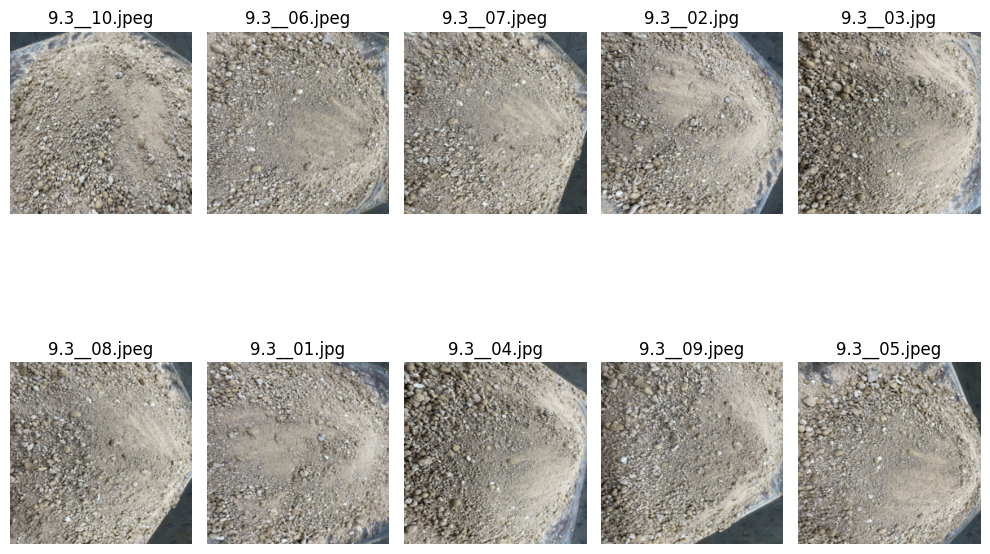

In [217]:
# Print some examples of augmented images

def preview_images(folder_path):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    image_files = [f for f in os.listdir(folder_path) if f.endswith(('.jpg', '.png', '.jpeg', '.bmp', '.JPEG'))]
    if len(image_files) == 0:
        print("No images found in the folder.")
    else:
        fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 8), squeeze=False)
        image_count = 0
        for i, image_file in enumerate(image_files):
            if image_count >= 10:
                break
            image_path = os.path.join(folder_path, image_file)
            try:
                image = transform(Image.open(image_path))
                image = image.permute(1, 2, 0)
                image = image * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])
                axes[image_count // 5, image_count % 5].imshow(image.numpy())
                axes[image_count // 5, image_count % 5].set_title(image_file)
                axes[image_count // 5, image_count % 5].axis('off')
                image_count += 1
            except Exception as e:
                print(f"Error loading image {image_path}: {e}")
        plt.tight_layout()
        plt.show()

folder_path = "./data/9.3"
preview_images(folder_path)

## Train


In [195]:
# Split your dataset into training, validation, and testing sets
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])


In [196]:
# Create data loaders for your dataset
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [4]:
# Define model architecture
class RegressionModel(nn.Module):
    def __init__(self):
        super(RegressionModel, self).__init__()
        self.feature_extractor = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)
        self.feature_extractor.fc = nn.Linear(512, 128)
        self.regression_head = nn.Linear(128, 1)

    def forward(self, x):
        x = self.feature_extractor(x)
        x = self.regression_head(x)
        return x

model = RegressionModel()

Using cache found in /Users/maggie.chao/.cache/torch/hub/pytorch_vision_v0.10.0
/Users/maggie.chao/Documents/Github/Water-Content-Model/.venv/lib/python3.13/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/maggie.chao/Documents/Github/Water-Content-Model/.venv/lib/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# Define a loss function and an optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

RegressionModel(
  (feature_extractor): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affi

In [228]:
# Train your model

num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    for batch in train_loader:
        images, labels = batch
        images = images.to(device)
        labels = labels.to(device).unsqueeze(1)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()
    model.eval()
    with torch.no_grad():
        val_loss = 0
        for batch in val_loader:
            images, labels = batch
            images = images.to(device)
            labels = labels.to(device).unsqueeze(1)
            outputs = model(images)
            loss = criterion(outputs, labels)
        val_loss += loss.item()
        print(f'Epoch {epoch+1}, Val Loss: {val_loss / len(val_loader)}')

Epoch 1, Val Loss: 1.0240294933319092
Epoch 2, Val Loss: 0.9753121534983317
Epoch 3, Val Loss: 0.8627826372782389
Epoch 4, Val Loss: 0.9732612768809
Epoch 5, Val Loss: 0.9514846007029215
Epoch 6, Val Loss: 1.0086859862009685
Epoch 7, Val Loss: 0.9709037144978842
Epoch 8, Val Loss: 1.0050794283548992
Epoch 9, Val Loss: 0.9249912103017172
Epoch 10, Val Loss: 0.8822083473205566


## Evaluate


In [229]:
def evaluate_model(model, test_loader, criterion, device):
    model.eval()
    test_loss = 0
    test_mae = 0
    test_mse = 0
    with torch.no_grad():
        for batch in test_loader:
            images, labels = batch
            images = images.to(device)
            labels = labels.to(device).unsqueeze(1)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            mae = torch.mean(torch.abs(outputs - labels))
            test_mae += mae.item()
            mse = torch.mean((outputs - labels) ** 2)
            test_mse += mse.item()
    test_loss /= len(test_loader)
    test_mae /= len(test_loader)
    test_mse /= len(test_loader)
    test_rmse = np.sqrt(test_mse)
    print(f'Test Loss: {test_loss:.4f}, Test MAE: {test_mae:.4f}, Test MSE: {test_mse:.4f}, Test RMSE: {test_rmse:.4f}')
    return test_loss, test_mae, test_mse, test_rmse

# Evaluate the model on the test set
test_loss, test_mae, test_mse, test_rmse = evaluate_model(model, test_loader, criterion, device)

Test Loss: 3.0674, Test MAE: 1.3468, Test MSE: 3.0674, Test RMSE: 1.7514


## Predict


In [235]:

def predict_water_content(model, image_path, device):
    # Load the image
    image = Image.open(image_path)

    # Preprocess the image
    transform = transforms.Compose([
        SquareCropAndResize(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    image = transform(image).unsqueeze(0).to(device)

    # Make a prediction
    model.eval()
    with torch.no_grad():
        output = model(image)
        water_content = output.item()

    return water_content

# Test the model on a new image
image_path = '9.3_tester.jpg'
water_content = predict_water_content(model, image_path, device)
print(f'Predicted water content: {water_content:.2f}')

Predicted water content: 11.90


In [236]:
# Save the model
torch.save(model.state_dict(), 'model.pth')